# Classification

Polarimetric radars measure both convectional information about scatterers (reflectivity and Doppler velocity) and additional information that is derived from two orthogonally polarised pulses (Z<sub>H</sub> and Z<sub>V</sub>). This additional information can be used to infer the scatterers shape, homeogenity and liquid water content. More specifically:

1. Z<sub>dr</sub> (Differential Reflectivity)
* ratio of Z<sub>H</sub> to Z<sub>V</sub> in dB
* scatterers with vertically aligned shapes return negative values, horitzontal shapes return positive values, purely chaotic or uniform shapes return zero. 
2. ρ<sub>hv</sub> (Co-polar Correleration Coefficient)
* correlation between Z<sub>H</sub> and Z<sub>V</sub> returns
* ρ<sub>hv</sub>→1 = increasingly homogenous
3. $\phi$<sub>dp</sub> (Differential Phase)
* phase shift between H and V polarisations.
* Raindrops are oblate when sampled horizontally, therefore the H pulse encounters more of the drops than V pulse producing a positive phase shift.

<br>

<img src="https://arrc.ou.edu/~guzhang/Polarimetry/img/intro/radarwave.png" alt="concept" width="600"/>

*Sketch of weather radar polarimetry principle. H and V denote the horizontal and vertical axes, respectively (source: https://arrc.ou.edu/~guzhang/Polarimetry/variables.htm)*

<br>

Using a combination of conventional and polarimetric information, it is possible to develop a robust classification of scatterer type. Thinking about this further, some examples are:

1. Moderate intensity rain: moderate Z<sub>H</sub>, very high ρ<sub>hv</sub>, positive Z<sub>dr</sub>, some $\phi$<sub>dp</sub>
1. Dry Hail: high Z<sub>H</sub>, moderate ρ<sub>hv</sub>, zero or negative Z<sub>dr</sub>, little or no $\phi$<sub>dp</sub>
1. Ground clutter: high Z<sub>H</sub>, noisy ρ<sub>hv</sub>, noisy Z<sub>dr</sub>, no $\phi$<sub>dp</sub>, no velocity
1. Dry Ice crystals: low to moderate Z<sub>H</sub>, high ρ<sub>hv</sub>, Z<sub>dr</sub> depends on alignment, little or no $\phi$<sub>dp</sub>,
1. Smoke: low to moderate Z<sub>H</sub>, low ρ<sub>hv</sub>, noisy Z<sub>dr</sub>, no $\phi$<sub>dp</sub>

Note that melting hail and ice crystals will change their shape and liquid water content. This also allows for the detection of the 'melting layer'.

For more information on the principles and applications of polarimetric weather radar, see Kumjian 2013 (doi: 10.15191/nwajom.2013.0119)

<br>

<img src="images/cp2-rhi.png" alt="CP-2 RHI" width="600"/>

### First let's download an OPOL to experiment with classifiers.

[Link](https://dapds00.nci.org.au/thredds/catalog/hj10/opol/level_1b/v2020/ppi/in2019_t03/20191225/catalog.html?dataset=hj10/in2019_t03/20191225/9776HUB-PPIVol-20191225-123000-0000.cfradial.nc) to original data source

In [4]:
import urllib.request
opol_vol_url= 'https://dapds00.nci.org.au/thredds/fileServer/hj10/opol/level_1b/v2020/ppi/in2019_t03/20191225/9776HUB-PPIVol-20191225-123000-0000.cfradial.nc'
opol_vol_local_ffn = 'data/9776HUB-PPIVol-20191225-123000-0000.cfradial.nc'
urllib.request.urlretrieve(opol_vol_url, opol_vol_local_ffn)

('data/9776HUB-PPIVol-20191225-123000-0000.cfradial.nc',
 <http.client.HTTPMessage at 0x7ff5bbcfcfa0>)

### We're going to experiment with using reflectivty (~scatterer intensity) and differential reflectivity (shape)

In [5]:
import pyart
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np

radar = pyart.io.read(opol_vol_local_ffn)

reflectivity = radar.fields['total_power']['data']
diff_reflectivity = radar.fields['differential_reflectivity']['data']

color_list = [
    "White", #None
    "MediumBlue", 
    "MediumPurple",
    "Green",
    "Red",
    ]
    
cmap = colors.ListedColormap(color_list)


### First let's create a simple (and very imperfect) classifier using reflectivity to distingush between grapuel/rain and everything else

(20.0, 60.0)

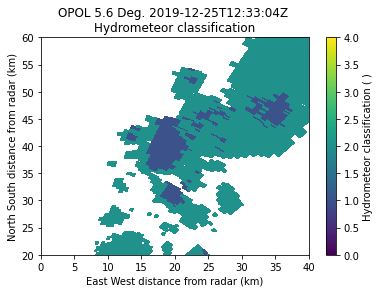

In [71]:
simple_classifier = np.zeros_like(reflectivity)

simple_classifier[reflectivity >= 30] = 1 #grapuel/rain
simple_classifier[reflectivity < 30] = 2 #everything else

radar.add_field_like('radar_echo_classification', 'simple_classification', simple_classifier, replace_existing=True)

fig, ax = plt.subplots()
gr = pyart.graph.RadarDisplay(radar)
gr.plot_ppi('simple_classification', sweep=6, vmin=0, vmax=4)
ax.set_xlim(0, 40)
ax.set_ylim(20, 60)

### Now let's use differential reflectivity to separate rain from grapuel

(20.0, 60.0)

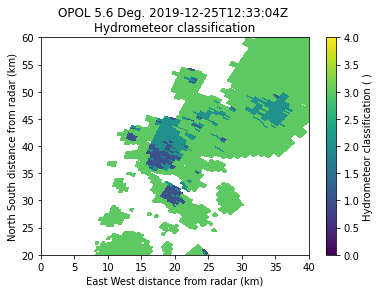

In [73]:
better_classifier = np.zeros_like(reflectivity)

better_classifier[np.logical_and(reflectivity >= 30, diff_reflectivity > 0.5)] = 1 #rain
better_classifier[np.logical_and(reflectivity >= 30, diff_reflectivity <= 0.5)] = 2 #grapuel
better_classifier[reflectivity < 30] = 3 #everything else

radar.add_field_like('radar_echo_classification', 'better_classification', better_classifier, replace_existing=True)

fig, ax = plt.subplots()
gr = pyart.graph.RadarDisplay(radar)
gr.plot_ppi('better_classification', sweep=6, vmin=0, vmax=4)
ax.set_xlim(0, 40)
ax.set_ylim(20, 60)

### We can take one step further and separate snow/light rain

(20.0, 60.0)

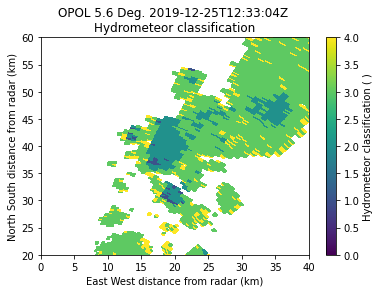

In [74]:
best_classifier = np.zeros_like(reflectivity)

best_classifier[np.logical_and(reflectivity >= 30, diff_reflectivity > 1)] = 1 #rain
best_classifier[np.logical_and(reflectivity >= 30, diff_reflectivity <= 1)] = 2 #grapuel
best_classifier[np.logical_and(reflectivity < 30, diff_reflectivity <= 1)] = 3 #snow or light rain
best_classifier[np.logical_and(reflectivity < 30, diff_reflectivity > 1)] = 4 #everything else

radar.add_field_like('radar_echo_classification', 'best_classification', best_classifier, replace_existing=True)

fig, ax = plt.subplots()
gr = pyart.graph.RadarDisplay(radar)
gr.plot_ppi('best_classification', sweep=6, vmin=0, vmax=4)
ax.set_xlim(0, 40)
ax.set_ylim(20, 60)

Looks like our classifier could be improved further by looking at the differential reflectivity threshold used for snow/light rain!

Now let's look at the Classification included with the level 1b file.
This is the Colorado State University Classification. Thompson et al. (2014) doi:10.1175/JTECH-D-13-00119.1

In [76]:
def adjust_csuhca_scheme_colorbar_for_pyart(cb):
    """
    Generate colorbar for the hydrometeor classification.
    """
    cb.set_ticks(np.linspace(0.5, 10.5, 11))
    cb.ax.set_yticklabels(
        [
            "None",
            "Driz",
            "Rain",
            "IceCry",
            "IceAgg",
            "W Snow",
            "V Ice",
            "LD Gpl",
            "HD Gpl",
            "Hail",
            "Big Dp",
        ]
    )
    cb.ax.set_ylabel("")
    cb.ax.tick_params(length=0)
    return cb

def csu_color_map():

    color_list = [
        "White", #None
        "LightBlue", #Driz
        "SteelBlue", #Rain
        "MediumBlue", #IceCry
        "Plum", #IceAgg
        "MediumPurple", #W Snow
        "m", #V Ice
        "Green", #LD Gpl
        "YellowGreen", #HD Gpl
        "Gold", #Hail
        "Red", #Big Dp
        ]
    
    return colors.ListedColormap(color_list)

def _plot_ppi(graph_obj, field_name, ax, vmin, vmax, cmap, sweep, pltrange, ring_list, gatefilter):
    """
    generated ppi plot for a given field using the graph object
    
    Parameters:
    ===========
        graph_obj: Py-ART graph object
        
        field_name: string
            field name
        ax: axis handle
        
        vmin: float
            min value for colormap in units of field
        vmax: float
            max value for colormap in units of field
        cmap: cmap name string from matplotlib or pyart
        
        sweep: int
            sweep index to plot
        range: int
            maximum range to plot i km
        ring_list: list of ints
            list of radius in km to plot range rings
        gatefilter: pyart gatefilter object
        
        basename: string
            output file basename
            
    Returns:
    ========
        None
    
    """
    #create ppi plot
    graph_obj.plot_ppi(field_name, sweep=sweep, ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_title(graph_obj.generate_title(field_name, sweep=sweep, datetime_format='%Y-%m-%dT%H:%M'))
    #annotate
    graph_obj.plot_range_rings(ring_list, ax=ax)
    ax.set_aspect(1)
    ax.set_xlim(0, 40)
    ax.set_ylim(20, 60)

Plot using the same sweep (6) as our basic classifiers

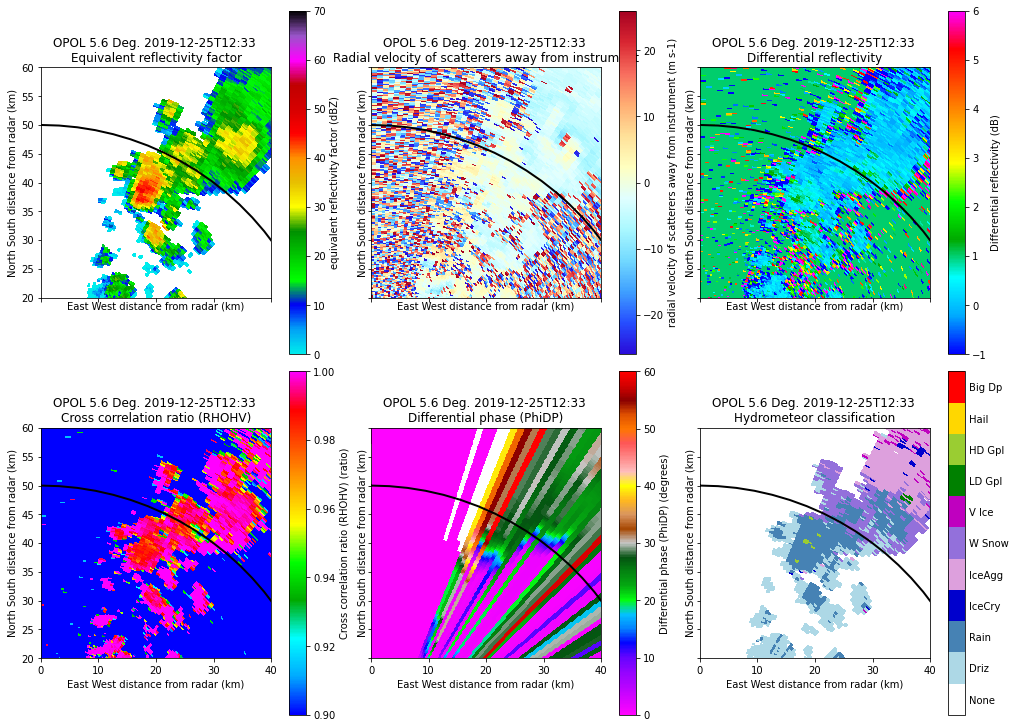

In [77]:
gr = pyart.graph.RadarDisplay(radar)
fig, the_ax = plt.subplots(2, 3, figsize=(14, 10), sharex=True, sharey=True, constrained_layout=True)
the_ax = the_ax.flatten()

plt_range = 75 #km
sweep = 6
gatefilter = pyart.correct.GateFilter(radar)

# corrected and calibrated reflectivity
_plot_ppi(gr, 'total_power', the_ax[0], vmin=0, vmax=70,
          cmap='pyart_NWSRef', sweep=sweep, pltrange=plt_range, ring_list=ring_list, gatefilter=gatefilter)
# Doppler velocity
_plot_ppi(gr, 'velocity', the_ax[1], vmin=-26, vmax=26,
          cmap='pyart_BuDRd12', sweep=sweep, pltrange=plt_range, ring_list=ring_list, gatefilter=gatefilter)
#differential reflectivity
_plot_ppi(gr, 'differential_reflectivity', the_ax[2], vmin=-1, vmax=6,
          cmap='pyart_RefDiff',sweep=sweep, pltrange=plt_range, ring_list=ring_list, gatefilter=gatefilter)
#cross_correlation_ratio
_plot_ppi(gr, 'cross_correlation_ratio', the_ax[3], vmin=0.9, vmax=1,
            cmap='pyart_RefDiff', sweep=sweep, pltrange=plt_range, ring_list=ring_list, gatefilter=gatefilter)  
#corrected_differential_phase
_plot_ppi(gr, 'corrected_differential_phase', the_ax[4], vmin=0, vmax=60,
          cmap='pyart_Wild25', sweep=sweep, pltrange=plt_range, ring_list=ring_list, gatefilter=gatefilter)    
        
csuhca_cmap = csu_color_map()
_plot_ppi(gr, 'radar_echo_classification', the_ax[5], vmin=0, vmax=11,
                          cmap=csuhca_cmap, sweep=sweep, pltrange=plt_range, ring_list=ring_list, gatefilter=gatefilter)
gr.cbs[-1] = adjust_csuhca_scheme_colorbar_for_pyart(gr.cbs[-1])

Plot using the surface sweep

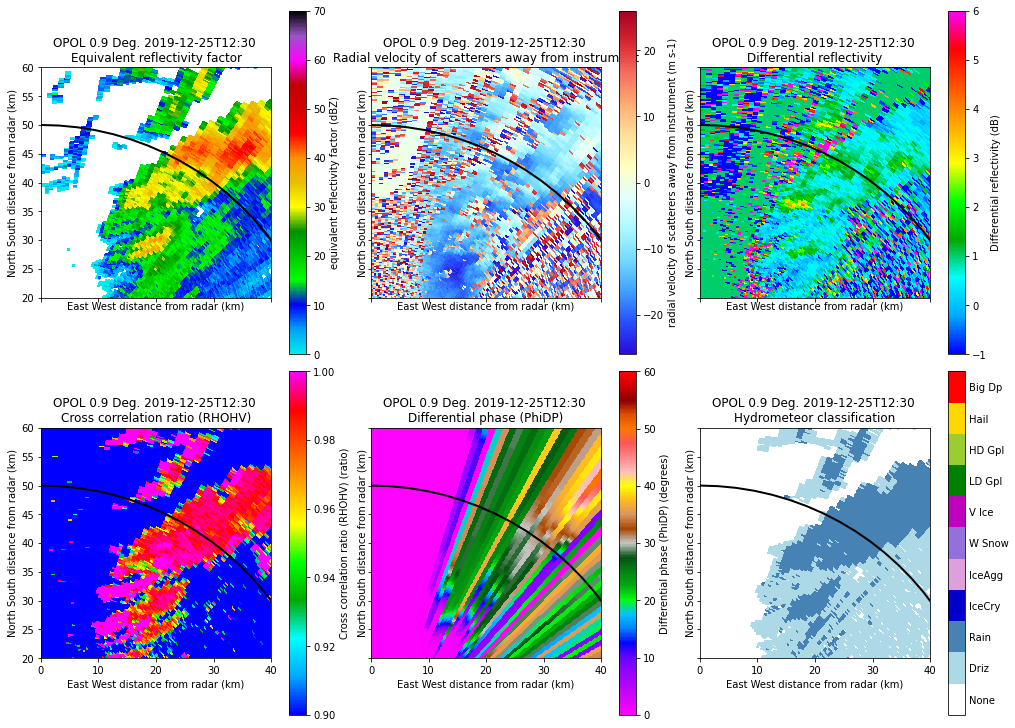

In [78]:
gr = pyart.graph.RadarDisplay(radar)
fig, the_ax = plt.subplots(2, 3, figsize=(14, 10), sharex=True, sharey=True, constrained_layout=True)
the_ax = the_ax.flatten()

plt_range = 75 #km
sweep = 0
gatefilter = pyart.correct.GateFilter(radar)

# corrected and calibrated reflectivity
_plot_ppi(gr, 'total_power', the_ax[0], vmin=0, vmax=70,
          cmap='pyart_NWSRef', sweep=sweep, pltrange=plt_range, ring_list=ring_list, gatefilter=gatefilter)
# Doppler velocity
_plot_ppi(gr, 'velocity', the_ax[1], vmin=-26, vmax=26,
          cmap='pyart_BuDRd12', sweep=sweep, pltrange=plt_range, ring_list=ring_list, gatefilter=gatefilter)
#differential reflectivity
_plot_ppi(gr, 'differential_reflectivity', the_ax[2], vmin=-1, vmax=6,
          cmap='pyart_RefDiff',sweep=sweep, pltrange=plt_range, ring_list=ring_list, gatefilter=gatefilter)
#cross_correlation_ratio
_plot_ppi(gr, 'cross_correlation_ratio', the_ax[3], vmin=0.9, vmax=1,
            cmap='pyart_RefDiff', sweep=sweep, pltrange=plt_range, ring_list=ring_list, gatefilter=gatefilter)  
#corrected_differential_phase
_plot_ppi(gr, 'corrected_differential_phase', the_ax[4], vmin=0, vmax=60,
          cmap='pyart_Wild25', sweep=sweep, pltrange=plt_range, ring_list=ring_list, gatefilter=gatefilter)    
        
csuhca_cmap = csu_color_map()
_plot_ppi(gr, 'radar_echo_classification', the_ax[5], vmin=0, vmax=11,
                          cmap=csuhca_cmap, sweep=sweep, pltrange=plt_range, ring_list=ring_list, gatefilter=gatefilter)
gr.cbs[-1] = adjust_csuhca_scheme_colorbar_for_pyart(gr.cbs[-1])

In [6]:
from sklearn import mixture

In [21]:
z = radar.fields['total_power']['data'].data.flatten()
zdr = radar.fields['differential_reflectivity']['data'].data.flatten()
cc = radar.fields['cross_correlation_ratio']['data'].data.flatten()

data = np.stack((z,zdr,cc),axis=1)

In [23]:
lowest_bic = np.infty
bic = []
n_components_range = range(2, 6)
cv_types = ["full"]
for n_components in n_components_range:
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(
        n_components=n_components, covariance_type="full"
    )
    gmm.fit(data)
    bic.append(gmm.bic(data))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm

NameError: name 'linalg' is not defined

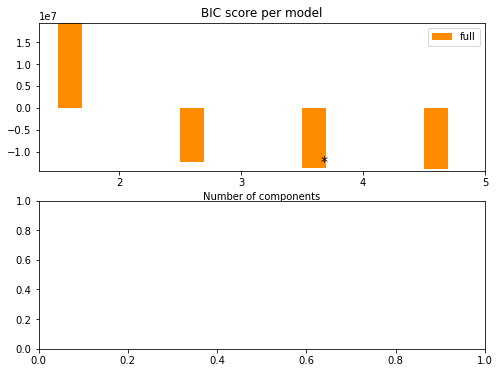

In [26]:
import itertools

bic = np.array(bic)
color_iter = itertools.cycle(["darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(data)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], data[Y_ == i, 1], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()